In [1]:
import pandas as pd
import rdkit
from rdkit import DataStructs, Chem
from rdkit.Chem import MACCSkeys, Draw
import torch
import numpy as np

## ZINC dataset


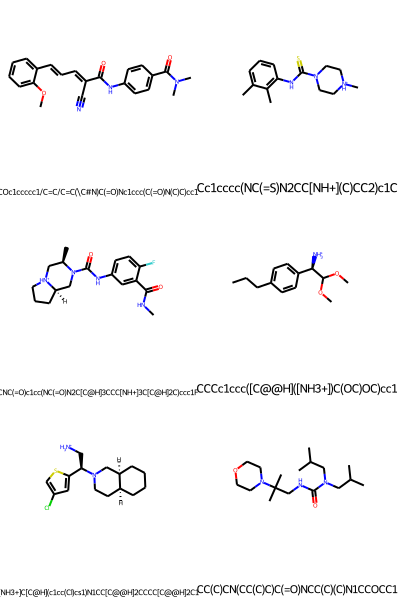

In [2]:

data = pd.read_csv('./data/train.txt', names=['SMILES'])

zinc_img = Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in list(data['SMILES'])[18:24]], molsPerRow=2,subImgSize=(200,200), legends=list(data['SMILES'])[18:24])
zinc_img

## Training of the JTVAE on ZINC dataset

In [19]:
# Vocabulary Generation
from fast_jtnn.mol_tree import main_mol_tree
main_mol_tree('./data/train.txt', './data/vocab.txt')

# Preprocessing of the data
from fast_molvae.preprocess import main_preprocess
main_preprocess('./data/train.txt', './fast_molvae/processed/', num_splits=100)

# Training of VAE (Caution - this will take time to run)
from fast_molvae.vae_train import main_vae_train
model = main_vae_train('./fast_molvae/processed/', './data/vocab.txt', './fast_molvae/vae_model/')

#Alternatively load our pretrained model
from fast_molvae.sample import load_model
model = load_model('./data/vocab.txt', './fast_molvae/vae_model/model.epoch-19').cuda()

## Generation of new molecules
To generate new molecules: It is really heavy, so try only to generate few molecules at the time. It creates a gaussian noise around the latent space of the molecule, which we want to replicate. Then it creates new molecules from similar latent space. 

In [2]:
data = pd.read_csv('./data/train.txt', names=['SMILES'])

from fast_molvae.sample import load_model
model = load_model('./data/vocab.txt', './fast_molvae/vae_model/model.epoch-19').cuda()

out_latent = model.encode_to_latent(data['SMILES'][3:4])

smiles = []
latent_space = []


for i in range(1):
    noise = np.random.normal(1,0.1, 56)
    noise = np.expand_dims(noise,axis = 0)
    noise = torch.from_numpy(noise).float().cuda()
    out_latent_noise= out_latent*noise

    z_t = out_latent_noise[0:1,0:28].cuda()
    z_mol = out_latent_noise[0:1,28:56].cuda()
    latent_space.append(out_latent_noise)
    smiles.append(model.decode(z_t, z_mol, False))
print(smiles[0])

# exporting the molecules

out_df = pd.DataFrame(smiles, columns = ['SMILES'])
out_df.to_csv('./latent_space/generated_moleculesX.txt')


OC1CC2(CNC3(C[SH]4CC5(OC6COC7CCCCC[N+]76C56CC=[NH+]CCC6)SCC4CS3)C2)[NH+]=C1OC12PCCN1CC1C3(CCCN3)C3NCCC132


## Tanimoto similarity
To create the similarities, we encoded it in many scripts, as we could only run tiny bits every time. The results were merged and loaded again through .txt files.
To produce the Tanimoto similarity, run below code:

In [8]:
data_smiles = pd.read_csv('./data/train.txt', names=['SMILES'])

from rdkit import DataStructs, Chem
original_mol = Chem.RDKFingerprint(Chem.MolFromSmiles(data_smiles['SMILES'][3]))
ms = []
for i in range(len(data_smiles)):
    ms.append(Chem.MolFromSmiles(data_smiles['SMILES'][i]))

fps = [Chem.RDKFingerprint(x) for x in ms]
tan_sim = []
for i in range(len(fps)): 
    tan_sim.append(DataStructs.FingerprintSimilarity(original_mol,fps[i]))

## Euclidian distance

In [9]:
data = pd.read_csv('./latent_space/encoded_ZINC_data.txt').drop(columns={'Unnamed: 0'})

def euclid(x,y):
    sqrtsum= 0
    xx = x.cpu().data.numpy()
    yy = y.cpu().data.numpy()
    for i in range(len(xx)):
        sqrtsum += (xx[0,i]-yy[0,i])**2
    EUClid = 1 / ( 1 + np.sqrt(sqrtsum))
    return EUClid


euc_list = []
chosen_mol = torch.tensor(data.iloc[3,:])
chosen_mol = chosen_mol.cuda().unsqueeze_(0)
r, j = data.shape
for i in range(len(data)):
    euc_list.append(  euclid( torch.tensor(data.iloc[i,:]).cuda().unsqueeze_(0) ,  chosen_mol  ))

## Log P Values


In [ ]:
#The log P values are created here.
data = pd.read_csv('./data/train.txt', names=['SMILES'])

from fast_molvae.sample import load_model
model = load_model('./data/vocab.txt', './fast_molvae/vae_model/model.epoch-19').cuda()

logP_values = model.logP_molecule(data['SMILES'], 1)
logP_values_df = pd.DataFrame(logP_values.cpu().data.numpy())
logP_values_df.to_csv('./latent_space/logP_values.txt')


No handles with labels found to put in legend.


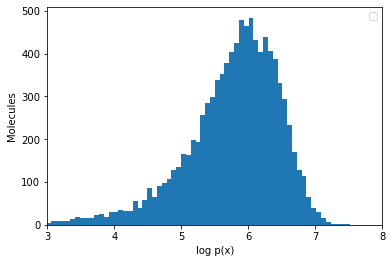

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(data_p_vals['logp'], bins= 100)
plt.ylabel('Molecules')
plt.xlabel('log p(x)')
plt.xlim([3,8])
plt.legend()

## Plotting and comparing tanimoto and euclidian distance
It is obvious from the plot, that the two different measurements has completely different results! 

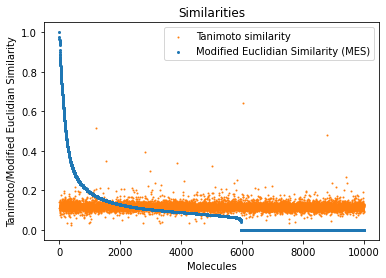

In [5]:
data_tan_eu = pd.read_csv('./latent_space/data_smiles_with_tanimoto_and_euclidian.txt').drop(columns={'Unnamed: 0'})
data_p_vals = pd.read_csv('./latent_space/logP_values.txt').drop(columns={'Unnamed: 0'})
data_p_vals['Tanimoto'] = data_tan_eu['Tanimoto_Similarity']
data_p_vals['Euclidean_distance'] = data_tan_eu['Euclidian_distance']


#
cut_off_value = 0.50
orig_mol_logP =  data_p_vals.iloc[3,0]

#
data_p_vals['cut_off'] =np.abs(data_p_vals['logp'] -  orig_mol_logP)
data_p_vals['novel_sim'] = data_p_vals['Euclidean_distance']
data_p_vals['novel_sim'].loc[data_p_vals['cut_off'] > cut_off_value] = 0

#data_p_vals.to_csv('./latent_space/measures_combined.txt')

data_smiles_copy = pd.read_csv('./latent_space/measures_combined.txt')

data_smiles_copy = data_smiles_copy.sort_values(by = 'novel_sim', ascending = False)
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(np.arange(0,len(data_smiles_copy)), data_smiles_copy['Tanimoto'], s = 1, label = 'Tanimoto similarity', c= 'tab:orange')
plt.scatter(np.arange(0,len(data_smiles_copy)),data_smiles_copy['novel_sim'], s = 4, label = 'Modified Euclidian Similarity (MES)', c  = 'tab:blue')
plt.title('Similarities')
plt.ylabel('Tanimoto/Modified Euclidian Similarity')
plt.xlabel('Molecules')
plt.legend()